# COG

## Initialise COG

In [1]:
%load_ext autoreload

# imports todo - fix this up properly
import os, certifi
os.environ['GDAL_DATA']  = r'C:\Program Files\ArcGIS\Pro\Resources\pedata\gdaldata'
os.environ.setdefault("CURL_CA_BUNDLE", certifi.where())

import os
import sys
import numpy as np
#import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import dask
import dask.array as da

sys.path.append('../../modules')
import cog

delete this!
remove this


### Set Globals (i.e. AWS keys)

In [2]:
# set globals
AWS_KEY = ''
AWS_SECRET = ''
STAC_ENDPOINT = 'https://explorer.sandbox.dea.ga.gov.au/stac/search'

### Set STAC query parameters

In [3]:
# get satellite collection on dea. todo get from user in arcgis, sentinel 2
collections = [
    'ga_ls5t_ard_3', 
    'ga_ls7e_ard_3',
    'ga_ls8c_ard_3'
]

# exclude slc
slc_off = False

# get satellite collection date range, convert to stac. todo get from user in arcgis
start_dt, end_dt = '1990-01-01', '1995-12-31'

# set temp boundary for testing
bbox = [
    118.93837524414061,
    -22.816061209792938,
    119.16526794433592,
    -22.68118293381927
    ]

# set search limits
limit = 200

### Fetch STAC data

In [4]:
# fetch results
feats = cog.fetch_stac_data(stac_endpoint=STAC_ENDPOINT, 
                            collections=collections, 
                            start_dt=start_dt, 
                            end_dt=end_dt, 
                            bbox=bbox,
                            slc_off=slc_off,
                            limit=limit)

Beginning STAC search for items. This can take awhile.
Searching collection: ga_ls5t_ard_3
Searching collection: ga_ls7e_ard_3
> Excluding SLC-off times.
Searching collection: ga_ls8c_ard_3
Sorting result by time (old to new).
Found a total of 146 scenes.


### Set COG parameters

In [5]:
# set required bands
assets = [
    'nbart_blue', 
    'nbart_green', 
    'nbart_red', 
    'nbart_nir',
    'nbart_swir_1',
    'nbart_swir_2',
    'oa_fmask'
]

# set resampling algorithm
resampling = 'nearest'

# set output dtype
out_dtype = 'int16'

# set out resolution
out_resolution = 30

# set fill value
out_fill_value = -999

# output epsg
out_epsg = 3577

# snap boundary coords
snap_bounds = True

# set output rescale
out_rescale = True

# chunk size
chunk_size=-1 #512

# set pixel location for cell alignment
out_pixel_loc = 'topleft'

### Prepare raw stac into useable format

In [6]:
# convert raw stac into dict with coord reproject, etc.
meta, asset_table = cog.prepare_data(feats, 
                                     assets=assets,
                                     bounds_latlon=bbox, 
                                     bounds=None, 
                                     epsg=out_epsg, 
                                     resolution=out_resolution, 
                                     snap_bounds=snap_bounds,
                                     force_dea_http=True)

Translating raw STAC data into numpy format.
Translated raw STAC data successfully.


### Convert data to dask array

In [7]:
# todo: go through todos in here, especially nodatareader

In [8]:
# NEED TO LOOK AT THIS FUNC AND MAKE IT YOURS
da_arr = cog.convert_to_dask(meta=meta, 
                             asset_table=asset_table, 
                             chunksize=chunk_size,
                             resampling=resampling, 
                             dtype=out_dtype, 
                             fill_value=out_fill_value, 
                             rescale=out_rescale)

Converting data into dask array.
Converted data successfully.


### Build xarray dataset

In [9]:
# generate coordinates and dimensions from metadata
coords, dims = cog.build_coords(feats=feats,
                                assets=assets, 
                                meta=meta,
                                pix_loc=out_pixel_loc)

# generate attributes
attrs = cog.build_attributes(meta=meta, 
                             fill_value=out_fill_value, 
                             collections=collections, 
                             slc_off=slc_off, 
                             bbox=bbox)

# build final xarray data array
ds = xr.DataArray(da_arr,
                  coords=coords,
                  dims=dims,
                  attrs=attrs,
                  name='stac-' + dask.base.tokenize(da)
                 )

# comvert to cleaner xarray dataset
ds = ds.to_dataset(dim='band')

### Compute and/or save dataset

In [10]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

# compute
#ds = ds.compute()

# save and re-open
fn = r'C:\Users\Lewis\Desktop\out_nc\test.nc'
ds.to_netcdf(fn)
ds = xr.open_dataset(fn)

[########################################] | 100% Completed |  2min  9.4s


### Drop invalid pixels and nodata values

In [14]:
# set fmask parameters
valid_class = [1, 4, 5]

# set max invalid percentage
max_invalid = 5

# set name of fmask
mask_band = 'oa_fmask'

# set the nodata value to replace fmask values with
nodata_value = np.nan

# drop mask band once done?
drop_fmask = True

# remove data where times invalid
ds = cog.remove_fmask_dates(ds, 
                            valid_class=valid_class,
                            max_invalid=max_invalid,
                            mask_band=mask_band,
                            drop_fmask=drop_fmask)

Removing dates where too many invalid pixels.


KeyError: 'oa_fmask'

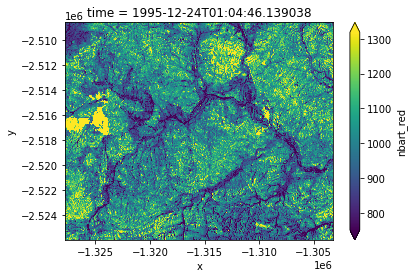

In [17]:
ds['nbart_red'].isel(time=-1).plot(robust=True)